#Von Karman vortex street

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondy}{\partial_y}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\drondyy}{\partial_{yy}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we consider the classical $\DdQq{2}{9}$ to simulate the Von Karman vortex street modeling by the Navier-Stokes equations.

In fluid dynamics, a Von Karman vortex street is a repeating pattern of swirling vortices caused by the unsteady separation of flow of a fluid around blunt bodies. It is named after the engineer and fluid dynamicist Theodore von Karman. For the simulation, we propose to simulate the Navier-Stokes equation into a rectangular domain with a circular hole of diameter $d$. 

The $\DdQq{2}{9}$ is defined by:

* a space step $\dx$ and a time step $\dt$ related to the scheme velocity $\lambda$ by the relation $\lambda=\dx/\dt$,
* nine velocities $\{(0,0), (\pm1,0), (0,\pm1), (\pm1, \pm1)\}$, identified in pyLBM by the numbers $0$ to $8$,
* nine polynomials used to build the moments
$$ \{1, \lambda X, \lambda Y, 3E-4, (9E^2-21E+8)/2, 3XE-5X, 3YE-5Y,X^2-Y^2, XY\},$$
where $E = X^2+Y^2$.

* three conserved moments $\rho$, $q_x$, and $q_y$,
* nine relaxation parameters (three are $0$ corresponding to conserved moments): $\{0,0,0,s_\mu,s_\mu,s_\eta,s_\eta,s_\eta,s_\eta\}$, where $s_\mu$ and $s_\eta$ are in $(0,2)$,
* equilibrium value of the non conserved moments
$$
\begin{aligned}\mke{3} &= -2\rho + 3(q_x^2+q_y^2)/(\rho_0\lambda^2), \\ \mke{4} &= \rho-3(q_x^2+q_y^2)/(\rho_0\lambda^2), \\ \mke{5} &= -q_x/\lambda, \\ \mke{6} &= -q_y/\lambda, \\ \mke{7} &= (q_x^2-q_y^2)/(\rho_0\lambda^2), \\ \mke{8} &= q_xq_y/(\rho_0\lambda^2),\end{aligned}
$$
where $\rho_0$ is a given scalar.

This scheme is consistant at second order with the following equations (taken $\rho_0=1$)
$$
\begin{gather*} \drondt\rho + \drondx q_x + \drondy q_y = 0,\\ \drondt q_x + \drondx (q_x^2+p) + \drondy (q_xq_y) = \mu \drondx (\drondx q_x + \drondy q_y ) + \eta (\drondxx+\drondyy)q_x, \\ \drondt q_y + \drondx (q_xq_y) + \drondy (q_y^2+p) = \mu \drondy (\drondx q_x + \drondy q_y ) + \eta (\drondxx+\drondyy)q_y,\end{gather*}
$$
with $p=\rho\lambda^2/3$.

We write a dictionary for a simulation of the Navier-Stokes equations on $(0,1)^2$.

In order to impose the boundary conditions, we use the bounce-back conditions to fix $q_x=q_y=\rho v_0$ at south, east, and north where the velocity $v_0$ could be $v_0=\lambda/20$. At west, we impose the simple output condition of Neumann by repeating the second to last cells into the last cells. 

The solution is governed by the Reynolds number $Re = \rho_0v_0d / \eta$, where $d$ is the diameter of the circle. Fix the relaxation parameters to have $Re=500$. The relaxation parameters related to the bulk viscosity $\mu$ should be large enough to ensure the stability (for instance $\mu=10^{-3}$).

We compute the stationary solution of the problem obtained for large enough final time. We plot the vorticity of the solution with the function imshow of matplotlib. 

In [1]:
%matplotlib inline

Reynolds number:  5.000e+02
Bulk viscosity :  1.000e-03
Shear viscosity:  1.000e-05
relaxation parameters: [0.0, 0.0, 0.0, 1.1312217194570136, 1.1312217194570136, 1.984757065735154, 1.984757065735154, 1.984757065735154, 1.984757065735154]


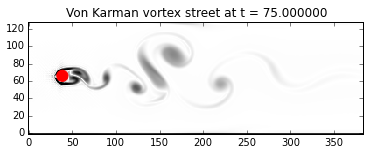

In [7]:
import numpy as np
import sympy as sp
import pyLBM

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc_in(f, m, x, y, scheme):
    m[:, 1] = rhoo * v0
    m[:, 2] = 0.
    scheme.equilibrium(m)
    scheme.m2f(m, f)

def vorticity(sol):
    ux = sol.m[0][1] / sol.m[0][0]
    uy = sol.m[0][2] / sol.m[0][0]
    V = np.abs(uy[2:,1:-1] - uy[0:-2,1:-1] - ux[1:-1,2:] + ux[1:-1,0:-2])/(2*sol.domain.dx)
    return -V
    
# parameters
rayon = 0.05
Re = 500
dx = 1./128  # spatial step
la = 1.      # velocity of the scheme
Tf = 75      # final time of the simulation
v0 = la/20   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-3   # bulk viscosity
eta = rhoo*v0*2*rayon/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax = 0., 3., 0., 1.
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rho)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

print "Reynolds number: {0:10.3e}".format(Re)
print "Bulk viscosity : {0:10.3e}".format(mu)
print "Shear viscosity: {0:10.3e}".format(eta)
print "relaxation parameters: {0}".format(s)

dico = {
    'box':{'x':[xmin, xmax], 'y':[ymin, ymax], 'label':[0,2,0,0]},
    'elements':[pyLBM.Circle([.3, 0.5*(ymin+ymax)+dx], rayon, label=1)],
    'space_step':dx,
    'scheme_velocity':la,
    'parameters':{LA:la},
    'schemes':[
        {
            'velocities':range(9),
            'conserved_moments':[rho, qx, qy],
            'polynomials':[
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters':s,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*q2,
                rho-3*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
            'init':{rho:rhoo, qx:0., qy:0.},
        },
    ],
    'boundary_conditions':{
        0:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':bc_in},
        1:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':None},
        2:{'method':{0: pyLBM.bc.neumann_vertical}, 'value':None},
    },
    'generator': pyLBM.generator.CythonGenerator,
}

sol = pyLBM.Simulation(dico)
while sol.t < Tf:
    sol.one_time_step()
    
viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig()
ax = fig[0]
im = ax.image(vorticity(sol).transpose(), clim = [-3., 0])
ax.ellipse([.3/dx, (0.5*(ymin+ymax)+2*dx)/dx], [rayon/dx,rayon/dx], 'r')
ax.title = 'Von Karman vortex street at t = {0:f}'.format(sol.t)
fig.show()